# Projet 5 : Segmenter des clients d'un site e-commerce

*Pierre-Eloi Ragetly*

Ce projet fait parti du parcours *Data Scientist* d'OpenClassroooms.

L'objectif pricipal est de réaliser **une segmentation des clients** d'un site de e-commerce, **une proposition de contrat de maintenance** devra être inclue.

Les données mises à notre disposition proviennent du site *kaggle* :
https://www.kaggle.com/olistbr/brazilian-ecommerce

# Partie II : Clustering

L'objectif de ce notebook est de décrire les opérations nécessaire à la segmentation des données.

nous lancerons le partionnement des données, après une rapide analyse de corrélation entre les variables. Quatre algorithmes seront testés:
- clustering hiérarchique
- k-means
- DBSCAN
- Gaussian misture

Le choix des différents hyperparamètres sera détaillé pour chaque algorithme. Une fois ces derniers définis, nous utiliserons **l'indice de Rand ajusté** afin de vérifier la stabilité des clusters. Le modèle de clustering permettant d'obtenir les clusters les plus stables sera sélectionné.

Une fois le meilleur partionnnement sélectionné, nous essaierons de caractériser les différents clusters en analysant les centroïdes via un heatmap. Nous utiliserons aussi l'algorithme de réduction *t-SNE* afin de pouvoir visualiser ces clusters.

In [28]:
# Import usual libraries
import numpy as np
import pandas as pd
import os
import time
import warnings

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'axes.titleweight': 'bold',
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    path = os.path.join("charts", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
dates_col = ["order_purchase_timestamp",
             "review_creation_date",
             "review_answer_timestamp"]
data = pd.read_csv("data/data.csv",
                   parse_dates=dates_col,
                   low_memory=False)

Pour les données, plusieurs test ont été effectués pour savoir notamment s'il était préférable d'utiliser les version discrétisées ou non des variables.  
Même si la discrétisation permet d'éviter d'avoir des outliers c'est au prix d'une perte de formation, et les tests ont montré que cette perte d'information entraînait une chute massive des performances (homogénéité et stabilité des clusters) de tous les algorithmes de clustering.

**C'est pourquoi dans la fonction ci-dessous, les paramètres *score* (pour obtenir les variables RFM sous forme de score de 1 à 5) et *binning* (permettant de discrétiser les autres variables) ont été assignés à la valeur *False*.**

In [3]:
from functions.wrangling import wrangling_pipeline

# Clean the data by using the pipeline detailed in the wrangling notebook
df_clean = wrangling_pipeline(data, m_mean=True,
                              score=False, binning=False)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mise-à-l'échelle-des-données" data-toc-modified-id="Mise-à-l'échelle-des-données-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mise à l'échelle des données</a></span></li><li><span><a href="#Étude-de-la-matrice-des-corrélations" data-toc-modified-id="Étude-de-la-matrice-des-corrélations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Étude de la matrice des corrélations</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Clustering-Hiérarchique" data-toc-modified-id="Clustering-Hiérarchique-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Clustering Hiérarchique</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>K-Means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DBSCAN</a></span></li><li><span><a href="#Mélange-Gaussien" data-toc-modified-id="Mélange-Gaussien-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Mélange Gaussien</a></span></li></ul></li><li><span><a href="#Stabilité-des-clusters" data-toc-modified-id="Stabilité-des-clusters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stabilité des clusters</a></span></li><li><span><a href="#Caractérisation-des-clusters" data-toc-modified-id="Caractérisation-des-clusters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Caractérisation des clusters</a></span><ul class="toc-item"><li><span><a href="#Caractérisation-des-clusters-avec-un-heatmap" data-toc-modified-id="Caractérisation-des-clusters-avec-un-heatmap-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Caractérisation des clusters avec un heatmap</a></span></li><li><span><a href="#Visualisation-des-clusters-avec-le-t-SNE" data-toc-modified-id="Visualisation-des-clusters-avec-le-t-SNE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Visualisation des clusters avec le t-SNE</a></span></li></ul></li></ul></div>

## Mise à l'échelle des données

Nous avons des variables avec des échelles différentes. En effet, certaines variables acceptent toutes les valeurs positives, d'autres variables, étant des proportions, ont une valeur entre 0 et 1. Il va donc falloir recalibrer les variables pour les mettre à la même échelle.  
**À noter que dans le cadre d'un problème supervisé, nous aurions au préalable séparé les données en jeu de test et d'entraînement pour obtenir des prédictions *saines***.

Les deux méthodes les plus utilisées sont :
- la *transformation min-max* (permettant d'obtenir des valeurs entre 0 et 1.
- la *normalisation* (on retranche la moyenne puis on divise par l'écart type)

Ces deux méthodes sont sensibles aux outliers (même si la normalisation l'est un peu moins), c'est pourquoi nous préférons utiliser la méthode *RobustScaler* (retranche la médiane, et met à l'échelle en divisant par l'écart interquartile) si les données en contiennent beaucoup.    
Vu que certaines variables sont des proportions (donc avec des entrées nulles), et qu'il serait souhaitable de préserver la structure des variables qualitatives, nous utiliserons la *transformation min-max* (à noter que si certaines variables avaient comporté des entrées négatives, nous aurions utiliser alors le *MaxAbsScaler* de manière à préserver les entrées nulles.)

**Nous changerons ensuite le poids des variables *RFM*, de manière à ce que ces trois dernières représentent 50% du poids total des variables.**

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Scale data with the MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df_clean.copy()
df_scaled.loc[:, :] = scaler.fit_transform(df_clean.values)

# Weight the RFM features
rfm_feat = ["Recency", "Frequency", "Monetary_value"]
n = df_scaled.columns.size
weight = (n-3) / 3
df_scaled.loc[:, rfm_feat] *= weight
X_scaled = df_scaled.values

## Étude de la matrice des corrélations

Un moyen facile de vérifier la présence de **corrélations linéaires** entre les couples de variables quantitatives est de calculer la matrice des corrélations. Cette matrice donne le coefficient de corrélation de Pearson pour chaque couple de variable. Nous tracerons cette matrice sous forme de *heat-map* qui permet de voir rapidement les variables les plus corrélées.

Nous ajouterons à cette matrice les *p-valeurs* du test de significativité associé. Lorque l'on effectue un test de significativité, il est préférable d'avoir une loi normale bivariée pour chaque couple de variable, ce qui permet d'avoir un test exact. Une condition nécessaire (mais non suffisante) de l'obtention d'une telle loi est que chaque variable suive une loi normale. Cependant étant donné que le nombre d'observations est grand, nous allons pouvoir effectuer un test asymptotique et nous affranchir de l'hypothèse de loi normale bivariée.

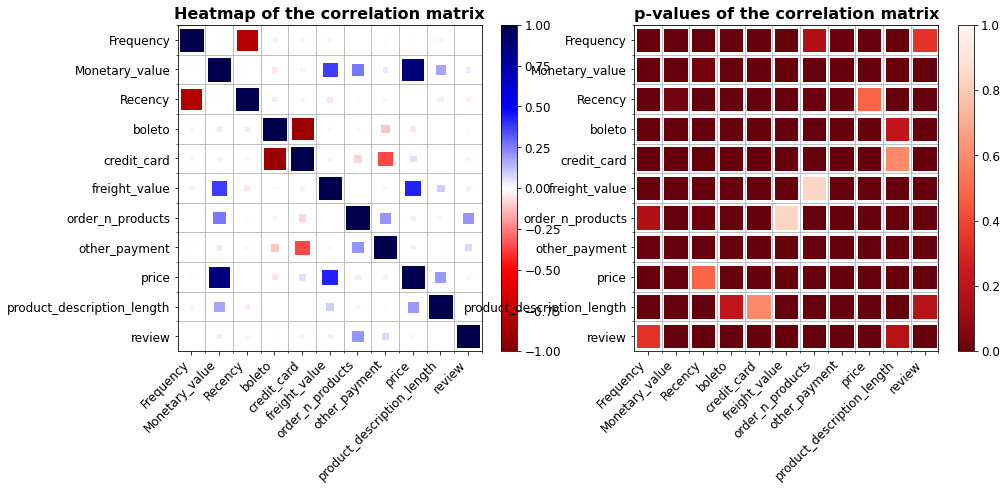

In [5]:
from functions.visualization import corr_plot

# Display the correlation array
corr_plot(df_scaled, size_scale=500)

Nous remarquons que les moyens de paiement sont bien corrélées entre eux, ce n'est pas étonnant vu qu'il s'agit de proportion et que chaque transaction est payée avec un seul moyen de paiement.

Autre point notable, et bien plus intéressant, c'est que la variable monétaire est bien plus corrélée au prix moyen du produit qu'au nombre de produits. Ce qui signifie que les clients ayant des paniers élevés **achètent des produits onéreux plutôt que des quantités importantes**.

## Clustering

### Clustering Hiérarchique

Pour débuter notre partitionnement nous allons utiliser une méthode hiérarchique agglomérative. Cette méthode est assez intuitive, elle consiste à considérer tous les points comme un cluster, puis à fusionner de manière itérative les clusters les plus proches jusqu'à en obtenir qu'un seul. Nous l'utiliserons afin d'avoir une idée du nombre de clusters à conserver. 

Pour savoir quels sont les clusters les plus proches il faut mesurer la distance qui les sépare. Pour cela l'algorithme a besoin de connaître deux paramètres :
- La métrique à utiliser
    - Euclidienne
    - Manhattan
    - Minkowski
    - Canberra
    - Cosinus
- La méthode à utiliser pout calculer la distance entre 2 clusters
    - lien simple (single linkage)
    - lien complet (complete linkage)
    - lien moyen (average linkage)
    - lien centroïdal (centroid linkage)
    - méthode de Ward
    
Pour la métrique cela dépendra du type de variable, si le jeu de données comporte uniquement des variables quantitatives (ce qui est notre cas) c'est la distance euclidienne qui sera utilisée. Pour un jeu de données hybride (variables quantitatives et qualitatives) ce sont les distances Manhattan ou Camberra qui seront préférées.

Les méthodes de lien définissent quels points des deux clusters utiliser pour calculer la distance. Ça peut être tous les points (average), les plus éloignés (complete), les centroïdes (centroid) ou les plus proches (single). Ces méthodes nous assurent des clusters bien éloignés, mais sont peu robustes aux outliers. Elles ont tendance à renvoyer des clusters comportant très peu d'individus (voire qu'un seul). Pour éviter cela nous pouvons utiliser la *méthode de Ward* qui, en cherchant à *minimiser la variance intraclasse*, permet d'obtenir des clusters bien plus homogènes. C'est pour cette raison que c'est celle qui est privilégiée en général, bien qu'elle demande plus de temps de calcul. Pour voir la différence entre une méthode de lien et la méthode de Ward, nous allons comparer le dendrogramme obtenu avec Ward au dendogramme obtenu avec un lien moyen.

les modèles de clustering agglomératif sont gourmands en temps de calcul, et ces derniers peuvent vite exploser pour les jeux de données de grande taille. Cependant, ce problème peut être contourné assez facilement en fournissant à l'algorithme une **matrice d'adjacence** (*connectivity matrix*). Il s'agit d'un matrice carrée qui indique si deux observations sont voisines. Nous pouvons l'obtenir très facilement avec la methode `kneigbors_graph()` de la classe *sklearn.neighbors*.

In [12]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(X, metric='euclidean', linkage='ward', **kwargs):
    """Function to plot a dendrogram.
    Parameters:
    X: Array
        the numpy object holding data
    metric: string, default euclidean
        the metric to be used    
    linkage: string, default ward
        the linkage method to be used
    -----------
    Return:
        matplotlib.axes.Axes
    """
    # Connectivity matrix
    connectivity = kneighbors_graph(X, n_neighbors=20,
                                    include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create the model
    model = AgglomerativeClustering(distance_threshold=0,
                                   n_clusters=None,
                                   affinity=metric,
                                   linkage=linkage,
                                   connectivity=connectivity)
    model.fit(X)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # Create the linkage matrix
    linkage_matrix = np.column_stack([model.children_,
                                     model.distances_,
                                     counts]).astype(float)
    # Plot the corresponding dendrogram
    plt.figure(figsize=(13, 9))
    dendrogram(linkage_matrix, **kwargs)
    plt.title("Hierarchical Clustering Dendrogram with {} linkage".format(linkage),
              fontsize=16)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")
    plt.ylabel("Distance")
    # Save the plot
    folder_path=os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    plt.savefig("charts/dendrogram_{}.png".format(linkage))
    plt.show()

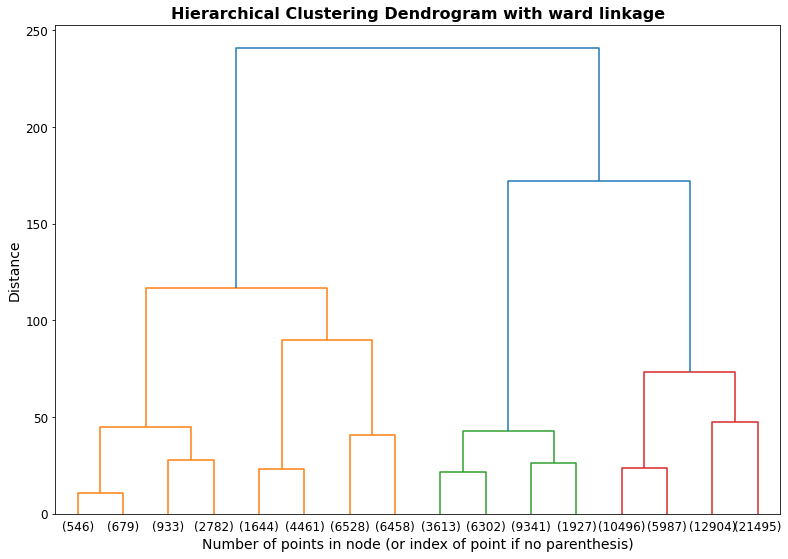

In [13]:
# plot the top three levels of the dendrogram with Ward linkage
plot_dendrogram(X_scaled, truncate_mode='level', p=3)

Nous observons que les clusters sont de tailles plutôt inégales, bien que nous ayons utilisé la méthode de Ward (ça risque d'être bien pire pour le lien moyen). Au vu du dendrogramme, le nombre idéal de clusters semble se situer entre 2 et 8 clusters. 

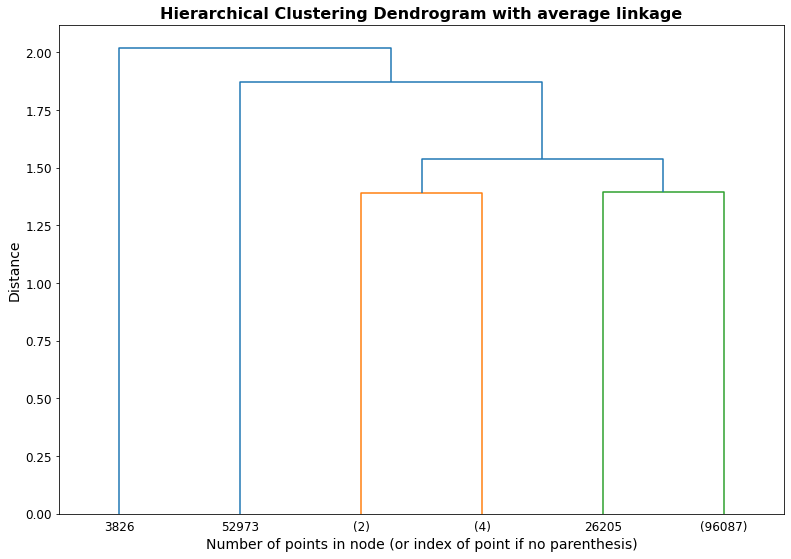

In [15]:
# plot the top three levels of the dendrogram with average linkage
plot_dendrogram(X_scaled, linkage="average", truncate_mode='level', p=3)

Comme nous le craignons, le lien moyen donne de très mauvais résultats. Il a eu tendance à créer un cluster par outlier et regrouper toutes les autres observations dans un unique cluster.

Ce modèle n'est clairement pas adapté à nos données.

Nous allons maintenant tester trois autres algorithmes de clustering:
- k-means: simple et rapide mais peu performant dès que les clusters ont des formes non sphériques ou des tailles différentes; 
- DBSCAN: robuste aux outliers, il permet d'identifier des clusters de n'importe quelle forme. Mais ses performances diminuent rapidement si la densité des clusters varie sensiblement;
- Gaussian Mistures: parfaitement adapté pour identifier des clusters de forme elliptique (peu importe la taille ou la direction) et de densités différentes.

Le choix de l'algorithme final se fera sur la *stabilité* des clusters, déterminé à l'aide du *coefficient de rand ajusté*.

### K-Means

Nous continuerons par l'algorithme le plus utilisé, le *K-Mean*.  
Son fonctionnement est assez simple, l'utilisateur rentre le nombre de clusters souhaités (k) puis l'algorithme initialise le modèle en choisissant aléatoirement k points parmi les observations du jeu de données. Ces k points seront considérés comme des centroïdes, l'agorithme va ensuite voir pour chaque observation quel est le centroïde qui est le plus proche et ainsi pouvoir lui attribuer un cluster. Puis l'algorithme va calculer les nouveau centroïdes des clusters ainsi formés. Il va ensuite itérer le processus (formation des clusters, calcul des centroïdes) jusqu'à obtenir une convergence (les  centroïdes ne bougent plus). Cette convergence est en général obtenu très rapidement (le K-Mean est l'un des algorithmes de clustering les plus rapides)

Du fait de l'attribution aléatoire des premiers centroïdes les résultats peuvent ne pas être stables (clusters différents à chaque fois que l'algorithme est lancé). Le k-means étant l'un des algorithmes de clustering le plus rapide, il peut être utile de lancer l'algorithme plusieurs fois et ensuite de garder le modèle avec la meilleure inertie (petite inertie intra-cluster, grande inertie inter-cluster). C'est ce que permet l'option n_init de la classe **KMeans** de *sklearn.cluster*.

Le K-Means a un seul hyperparamètre &ndash; *le nombre de clusters* &ndash;, mais ce dernier n'est pas toujours évident à trouver.  
La méthode la plus simple est de tracer le *R2* (inertie inter-classe / inertie totale) pour plusieurs k différents. Comme R2 augmente avec k, nous n'allons pas chercher à maximiser R2 mais essayer de trouver le k au-dessus duquel nous n'avons pas d'augmentation significative du R2, c'est **la méthode du coude**.  
Cette méthode est plutôt grossière, c'est pourquoi il est en général préféré d'utiliser le coefficient de silhouette. Technique plus fine mais plus gourmande en temps de calcul. Ce coefficient entre -1 et 1 permet de voir si une observation a été attribuée au bon cluster (>0).

La fonction ci-dessous permet de comparer les deux méthodes en les traçant sur le même graphique. À noter que si la classe KMeans de scikit-learn possède un attribut `inertia_`, ce dernier somme le carré des distances entre chaque observation et le centroïde le plus proche. S'il est toujours possible d'utiliser la méthode du coude avec cet attribut, cela donne des valeurs difficilement interprétables. C'est pourquoi il a été préféré ici de calculer le R2, au lieu d'utiliser directement la valeur renvoyée par cet attribut.

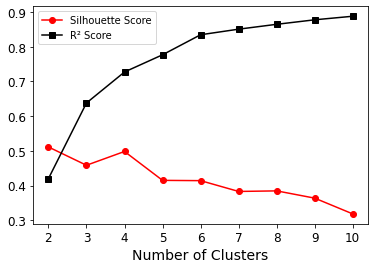

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Get the models for different k
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled)
                for k in range(2, 11)]
# Compute the R2 score
total_inertia = np.var(X_scaled, axis=0).sum()
intra_inertia = [model.inertia_/len(X_scaled)
                 for model in kmeans_per_k]
r2_scores = [1 - inertia/total_inertia
             for inertia in intra_inertia]

# Compute the silhouette score
sample_size = int(X_scaled.shape[0]*0.2)
s_scores = [silhouette_score(X_scaled, model.labels_,
                             metric='euclidean',
                             sample_size=sample_size,
                             random_state=42)
            for model in kmeans_per_k]

# Create the plot
plt.plot(range(2, 11), s_scores, "ro-", label="Silhouette Score")    
plt.plot(range(2, 11), r2_scores, "ks-", label="R² Score")
plt.xlabel("Number of Clusters")
plt.legend(loc="best")
plt.show()

$k$ = 3 semble être le meilleur choix, à noter que $k$ = 2 donne aussi de bons résultats.

Il est possible d'affiner encore un peu plus les résultats, en traçant les observations regroupées par cluster et triées par le coefficient de silhouette associé.

Saving figure silhouette_analysis_diagram


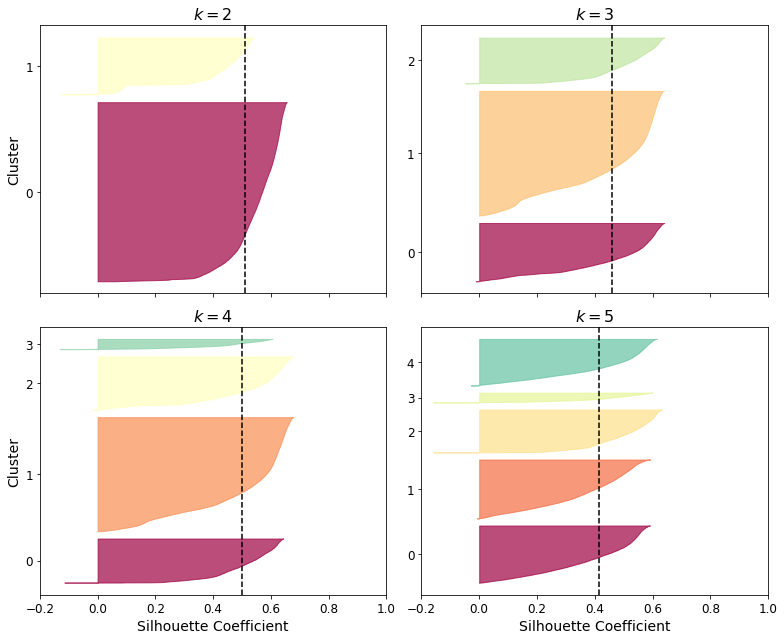

In [17]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in [2, 3, 4, 5]:
    plt.subplot(2, 2, k-1)
    
    y_pred = kmeans_per_k[k-2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=s_scores[k - 2], color="k", linestyle="--")
    plt.title("$k={}$".format(k))

save_fig("silhouette_analysis_diagram")
plt.show()

Nous pouvons observer que pour $k$ = 4, 5 et 7 les cluster avec les index respectivement 2, 2 et 5 sont plutôt mauvais (la quasi-totalité des observations ont un score de silhouette inférieur au score moyen).
Sinon pout tous les $k$ nous avons des clusters de taille plutôt homogène.

**Le nombre optimal de clusters pour le K-Means est bien $k$ = 3.** 

### DBSCAN

Nous allons maintenant utiliser l'algorithme du DBSCAN et voir combien de clusters il nous renvoie.

Cet algorithme crée des clusters en groupant les observations de proche en proche par densité. Pour chaque observation, l'algorithme va compter (en l'incluant elle même) le nombre d'observations se trouvant dans son voisinage (défini par la distance $\epsilon$). Si le nombre d'observations est supérieur au seuil *min_samples*, alors cette observation est considérée comme une observation *cœur* et l'algorithme crée un cluster. Toutes les observations inclues dans le voisinage de cette observation cœur sont considérées comme appartenant à ce cluster. L'algorithme va ensuite chercher à propager le cluster de proche en proche, en vérifiant si les observations au voisinage ne sont pas elles mêmes des observations cœurs. Ainsi, deux observations éloignées l'une de l'autre, peuvent se retrouver dans le même cluster si on peut trouver entre elles une succession d'observations cœurs. Les observations isolées (qui diffèrent grandement des autres, on parle alors d'outliers) ne seront pas intégrées dans un cluster et ne seront donc pas classées. Ce qui rend l'algorithme du DBSCAN robuste aux ouliers.

L'utilisation de DBSCAN requière la configuration de deux hyperparamètres :

- $\epsilon$ : il s'agit de la distance minimale nécessaire entre deux observations pour qu'elles soient considérée comme voisines.
- *min_samples* : il s'agit du nombre minimal d'observations devant appartenir au voisinage d'une autre pour que cette dernière soit considérée comme une observation cœur.

Il peut ne pas être toujours évident de déterminer ces hyperparamètres. Si en général l'avis d'un expert (qui connaît très bien les données étudiées) est souhaitable, il existe cependant des méthodes empiriques permettant d'obtenir une assez bonne approximation des valeurs souhaitées.

Il est préférable de commencer par déterminer l'hyperparamètre *min_samples* car nous en aurons ensuite besoin pour déterminer l'hyperparamètre $\epsilon$. Il est important de noter que la valeur de *min_samples* devra toujours être strictement supérieure à 2 (et supérieure à D + 1, D étant le nombre de variables dans le jeu de données). Comme l'algorithme DBSCAN considère chaque observation comme étant inclue dans son propre voisinage, prendre une valeur de 1 pour *min_samples* revient alors à considérer que **chaque observation est une observation coeur et donc notamment créer un cluster par outlier**. Quant à prendre une valeur de 2, ça revient à faire un clustering hiérarchique avec un lien simple (en arrêtant le dendrogramme à une hauteur $\epsilon$.).  
La règle du pouce nous incite à commencer par tester  
$$\text{min_samples} = 2 \times D$$
Pour les jeux de données volumineux ou pas/peu nettoyés (présence de nombreux doublons et/ou outliers) il pourra être nécessaire de prendre une valeur plus importante.  
Ici, le jeu de données ayant été nettoyé et de taille restreinte, nous suivrons la règle du pouce et prendrons **min_samples = 22** (2 x 11).

Ayant déterminé *min_samples*, nous pouvons nous pencher sur $\epsilon$. Nous allons commencer par calculer la distance du kième plus proche voisin de chaque observation, avec k = min_samples (min_samples - 1 si l'algorithme utilisé n'inclue pas l'observation elle même parmi ses voisins). Puis nous allons trier ces distances par odre décroissant de manière à tracer un *k-distance graph*. Enfin nous utiliserons la méthode du coude (endroit où il y a une rupture de pente formant une sorte de coude) pour déterminer $\epsilon$.

Saving figure k-distance_graph


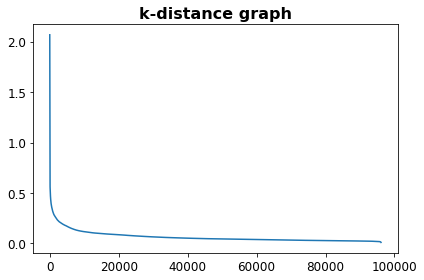

In [18]:
from sklearn.neighbors import NearestNeighbors

# Compute the distances of the k nearest neighbors
k = 22
k_neighbors = NearestNeighbors(n_neighbors=k)
k_neighbors.fit(X_scaled)
distances, indices = k_neighbors.kneighbors(X_scaled)
# Keep only the kth neighbor distance
k_distance = distances[:, -1]
# Sort by descending order
k_distance = np.sort(k_distance)[::-1]
# Plot the k-distance graph
plt.plot(k_distance)
plt.title("k-distance graph")
save_fig("k-distance_graph")
plt.show()

Nous observons très nettement le coude qui se trouve à une distance de 0,2 environ.  
**Nous prendrons donc $\epsilon$ = 0,2**.

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=22)
dbscan.fit(X_scaled)
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

Nous obtenons 8 cluster, ce qui est un peu plus qu'avec l'algorithme K-Means.

### Mélange Gaussien

Nous allons maintenant tester notre dernier modèle, le modèle de *mélange Gaussien* (en anglais, *Gaussian mixture model* ou GMM). Il s'agit d'un modèle probabiliste qui fait l'hypothèse que les observations ont été générées à partir de plusieurs distributions gaussiennes. L'algorithme cherchera à caractériser ces distributions (moyenne et matrice de covariance)
C'est un modèle qui permet de former des clusters d'orientation, de taille, de densité différentes. Ces clusters auront tous une forme ellipsoïdale du fait de l'hypothèse Gaussienne des distributions. Ce modèle peut donc vite donner des résultats médiocres si la forme des clusters s'écartent d'une ellipse. En revanche, si l'on suspecte que les données proviennent de distribution normales, ça sera certainement le modèle qui donnera les meilleurs résultats.  
Il s'agit de l'un des modèles les plus utilisés pour la détection.

Il existe plusieurs variantes de modèles de mélange gaussien, dans la variante la plus simple il faut rentrer en hyperparamère le nombre de distributions gaussiennes(donc le nombre de clusters). Ce modèle se fonde sur l'algorithme de d'*espérance-maximisation* (*expectation-maximization* ou EM en anglais). Cet algorithme présente de nombreuses similitudes avec l'algorithme du k-means. Il s'agit de répéter deux étapes, attribution des observations à un cluster (étape *espérance*) et mise à jour des clusters (étape de *maximisation*) jusqu'à obtenir une convergence. Cependant, contrairement à *K-Means*, *EM* effectue des affectations souples.

Tout comme nous avions utilisé le coefficient de silhouette pour trouver le meilleur nombre de clusters pour *K-Means*, nous pouvons utiliser certaines métriques pour trouver le bon nombre de distributions. Il s'agit des critères d'information *BIC* (*Bayesian information criterion*) ou *AIC* (*Akaike Information criterion*) que nous chercherons à minimiser. Bien souvent, ils donneront des résultats similaires. Une autre méthode consiste à utiliser un modèle de *mélange gaussien bayésien*. On donne au modèle une valeur dont nous savons (ou avons de bonnes raison de penser) qu'elle est supérieure au nombre optimal de clusters. Le modèle va alors attribuer un poids nul (ou presque) aux clusters non nécessaires.

Saving figure aic&bic_vs_k


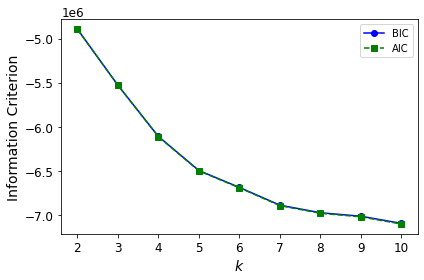

In [20]:
from sklearn.mixture import GaussianMixture

# Train Gaussian Mixture with various values of k
gm_per_k = [GaussianMixture(n_components=k,
                            n_init=10,
                            random_state=42).fit(X_scaled)
            for k in range(2, 11)]

# Compute both their BIC & AIC
bics = [model.bic(X_scaled) for model in gm_per_k]
aics = [model.aic(X_scaled) for model in gm_per_k]

# Create the plot
plt.plot(range(2, 11), bics, "bo-", label="BIC")
plt.plot(range(2, 11), aics, "gs--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.legend(loc="best")
save_fig("aic&bic_vs_k")
plt.show()

Nous constatons que les résultats sont fort différents de ceux obtenus avec les autres méthodes de clustering. Plus k augmente, meilleurs sont les résultats. Ainsi, nous obtenons les meilleurs résultats (AIC & BIC minimum) pour $k$ = 10, qui était le $k$ maximum renseigné. Nous pourrions tester des $k$ plus grands, et voir lequel donne les meilleurs résultats, mais ce serait une perte de temps. Au vu des courbes, le modèle de mélange Gaussien ne semble pas adapté aux données. Certainement parce que les données ne proviennent pas de distributions Gaussiennes.

**Nous n'irons donc pas plus loin avec ce modèle et poursuivrons uniquement avec les trois modèles présentés précédemment.**

## Stabilité des clusters

Nous allons maintenant choisir un modèle de clustering parmi les trois présenté précédemment :
- AgglomerativeClustering(n_clusters=3, linkage='ward')
- KMeans(n_clusters=3)
- DBSCAN(eps=0.2, min_samples=22)

Pour cela nous allons vérifier la stabilité de clusters renvoyés par chaque modèle et sélectionnerons celui qui renvoie les clusters les plus stables.  
Pour mesurer la stabilité, nous utiliserons *l'indice de Rand ajusté*, cet indice donne la similarité entre deux partitions. Nous allons entrainer les trois modèles sur un jeu de données prenant en compte uniquement les transactions antérieures à une date de référence &ndash; la date de la dernière transaction moins 12 mois. Puis, nous comparerons les résultats obtenus à ceux obtenus avec les mêmes modèles mais entrainés sur des jeux de données incluant des transactions postérieurs à la date de référence :
- date de référence + 1 mois
- date de référence + 2 mois
- date de référence + 3 mois
- date de référence + 6 mois
- date de référence + 12 mois

L'évolution de l'indice de Rand ajusté nous permettra de déterminer la stabilité des clusters, ainsi que la fréquence à laquelle devra être mis à jours le modèle (chute de l'indice de Rand Ajusté).

In [21]:
def clustering_algorithms(X):
    """Builds the following clustering models:
    - Agglomerative clustering with the Ward linkage
    - K-Means
    - DBSCAN
    X: Array
        the numpy object holding data
    -----------
    Return:
        list of models
    """
    # Connectivity matrix
    connectivity = kneighbors_graph(X, n_neighbors=30,
                                    include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create the models
    ward = AgglomerativeClustering(n_clusters=3,
                                   linkage='ward',
                                   connectivity=connectivity)
    kmeans = KMeans(n_clusters=3, random_state=42)
    dbscan = DBSCAN(eps=0.2, min_samples=22)

    return (ward, kmeans, dbscan)

In [23]:
# Get the reference date as well as the dates with time delta
max_date = data["order_purchase_timestamp"].max()
time_delta = np.timedelta64(12, 'M')
ref_date = max_date - time_delta
dates_delta = [ref_date + np.timedelta64(m, 'M')
             for m in [1, 2, 3, 6, 12]]

# Get data for the reference date
df_ref = wrangling_pipeline(data, ref_date=ref_date, m_mean=True,
                        score=False, binning=False)
idx = df_ref.index
# Scale data with the MinMaxScaler
scaler = MinMaxScaler()
df_ref.loc[:, :] = scaler.fit_transform(df_ref.values)
# Weight the RFM features
rfm_feat = ["Recency", "Frequency", "Monetary_value"]
n = df_ref.columns.size
weight = (n-3) / 3
df_ref.loc[:, rfm_feat] *= weight
X_ref = df_ref.values


# Get data for each date plus time delta
df_per_date=[]
for date in dates_delta:
    df = wrangling_pipeline(data, ref_date=date, m_mean=True)
    df.loc[:, :] = scaler.fit_transform(df.values)
    df.loc[:, rfm_feat] *= weight
    df_per_date.append(df)
idx_per_date = [df.index.isin(idx)
                for df in df_per_date]
X_per_date = [df.values for df in df_per_date]

Comparons les indices de Rand ajustés pour vérifier la stabilité des clusters.

Saving figure rand_index


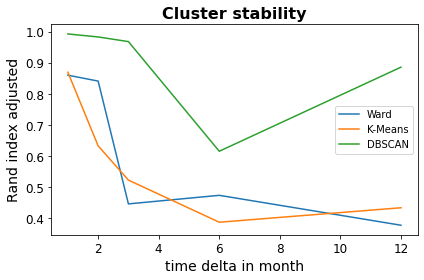

In [24]:
from sklearn.metrics import adjusted_rand_score

# Train the reference models
models_ref = clustering_algorithms(X_ref)
for models in models_ref:
    models.fit(X_ref)
labels_ref = [model.labels_ for model in models_ref]

# Initialize the Rand score array
n = len(dates_delta)
p = len(models_ref)
rand_scores = np.empty((n, p))

# Compute the rand index adjusted
for i, X in enumerate(X_per_date):
    models = clustering_algorithms(X)
    for j, model in enumerate(models):
        model.fit(X)
        labels = model.labels_[idx_per_date[i]]
        rand_scores[i, j] = adjusted_rand_score(labels, labels_ref[j])
        
# Plot the results
for k, name in enumerate(["Ward", "K-Means", "DBSCAN"]):
    plt.plot([1, 2, 3, 6, 12], rand_scores[:, k], label=name)
plt.xlabel("time delta in month")
plt.ylabel("Rand index adjusted")
plt.legend()
plt.title("Cluster stability")
save_fig("rand_index")
plt.show()  

Nous constatons que le modèle DBSCAN renvoie des clusters bien plus stables, c'est donc celui que nous utiliserons. De plus, nous constatons une chute des performances après 3 mois.  
**Il faudra donc veiller à mettre à jour le modèle une fois par trimestre.**

Nous observons une remonté des performances après 12 mois, ce qui pourrait indiquer que bon nombre des clients ont tendance à faire leurs achats à la même période de l'année (courses de Noël ?)

## Caractérisation des clusters

### Caractérisation des clusters avec un heatmap

Nous allons maintenant chercher à déterminer le client type de chaque cluster.  
Contrairement au K-Means, nous n'avons pas de méthode qui permettent d'obtenir directement les centroïdes. Nous ne pouvons donc pas faire directement un heatmap des centroïdes. En revanche nous pouvons faire une heatmap des points représentatifs de ces clusters.

Pour trouver ces points représentatifs, nous allons passer par un modèle des k plus proches voisins (knn). Nous allons entraîner ce knn sur les résultats donnés par DBSCAN (en ne gardant que les observations coeur) puis, nous regarderons pour chaque observations les probabilités d'obtenir à tel ou tel cluster. Le point représentatif d'un cluster k, sera celui ayant la plus forte probabilité d'appartenir à ce cluster.

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Train a knn based on labels given by DBSCAN
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

# get the index of the most representative samples
idx_heatmap = np.argmax(knn.predict_proba(X_scaled[dbscan.core_sample_indices_]), axis=0)

Nous pouvons maintenant tracer le heatmap

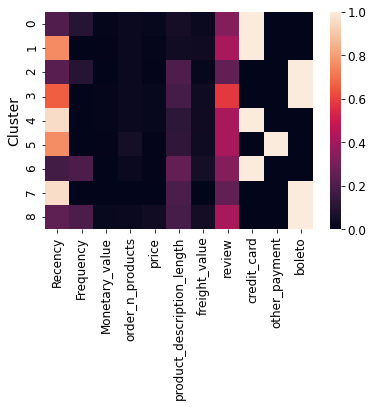

In [34]:
df_heatmap = df_clean.iloc[dbscan.core_sample_indices_].iloc[idx_heatmap].copy()
# Scale data to get a [0, 1] range for each sample
scaler = MinMaxScaler()
scaler.fit(df_clean.values)
df_heatmap.loc[:, :] = scaler.transform(df_heatmap.values)
# Reset the index with labels
df_heatmap["Cluster"] = dbscan.labels_[dbscan.core_sample_indices_][idx_heatmap]
df_heatmap.set_index("Cluster", inplace=True)

# Plot the heatmap
ax = sns.heatmap(df_heatmap)

### Visualisation des clusters avec le t-SNE